In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, words
import nltk

# Download necessary nltk resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# Define stopwords list
specific_stopwords = ["https", "subreddit", "www", "com"] ## some specific words for the given dataset
stopwords_list = stopwords.words('english') +specific_stopwords + stopwords.words('french') # dataset is both in english and in french


[nltk_data] Downloading package punkt to /home/clatimie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clatimie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clatimie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load training data
file_path = '../datasets/Train.csv'
train_data = pd.read_csv(file_path, header=None, skiprows=1, names=["text", "subreddit"])

# Define lemmatizer outside of the function to ensure it's initialized
lemmatizer = WordNetLemmatizer()

# Updated preprocessing function
def preprocess_text(text):
    # Tokenize and convert text to lowercase
    words = word_tokenize(text.lower())
    
    # Lemmatize words and filter out stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stopwords_list]
    
    # Join the words back into a string and return
    return ' '.join(words)

# Apply preprocessing to the training data
train_data['processed_text'] = train_data['text'].apply(preprocess_text)
print(train_data.head())

# Split data into training and validation sets
X = train_data['processed_text']
y = train_data['subreddit']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text using CountVectorizer with binary=True for binary feature representation
vectorizer = CountVectorizer(max_features=3000, binary=True)
X_train_binary = vectorizer.fit_transform(X_train).toarray()
X_val_binary = vectorizer.transform(X_val).toarray()


                                                text subreddit  \
0  /r/Toronto and the Toronto Public Library enco...   Toronto   
1  Investor owners of condos have been forcing co...   Toronto   
2  I'm sure someone has run the numbers to ensure...   Toronto   
3  >There I said it...Toronto with their WNBA fra...   Toronto   
4  Considering the roadway is finally cleared thi...   Toronto   

                                      processed_text  
0  toronto public library encourage support local...  
1  investor owner condo forcing condo board defer...  
2  sure someone run number ensure physic side way...  
3  said toronto wnba franchise 2026 playing scoti...  
4  considering roadway finally cleared make sense...  


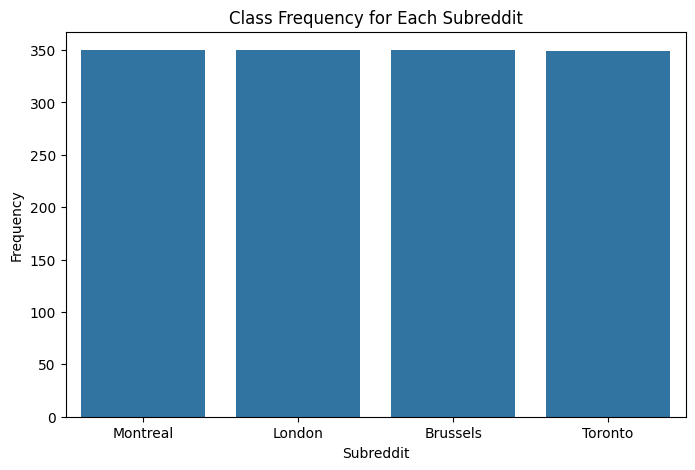

In [3]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train_data, x='subreddit', order=train_data['subreddit'].value_counts().index)
plt.title('Class Frequency for Each Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Frequency')
plt.show()


/tmp/ipykernel_12579/1419712119.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")
/tmp/ipykernel_12579/1419712119.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")
/tmp/ipykernel_12579/1419712119.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")
/tmp/ipykernel_12579/1419712119.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0

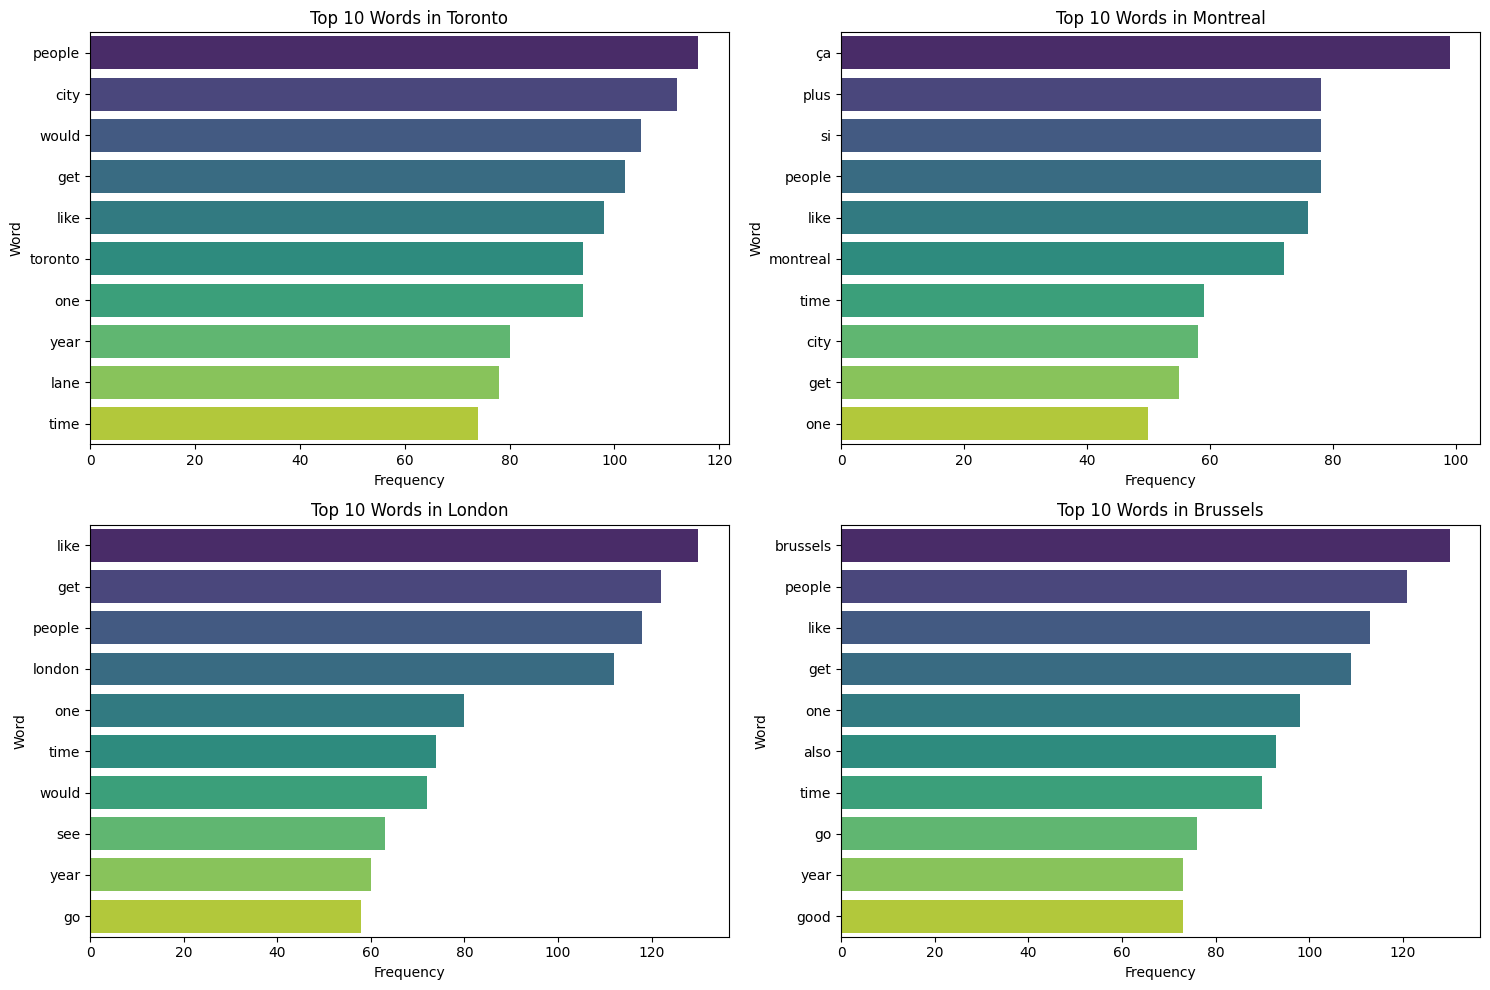

In [4]:
from collections import Counter

def get_top_words(class_name, n=10):
    text = ' '.join(train_data[train_data['subreddit'] == class_name]['processed_text'])
    words = text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)

plt.figure(figsize=(15, 10))
subreddits = train_data['subreddit'].unique()
for i, subreddit in enumerate(subreddits, 1):
    top_words = get_top_words(subreddit)
    words, counts = zip(*top_words)
    plt.subplot(2, 2, i)
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(f'Top 10 Words in {subreddit}')
    plt.xlabel('Frequency')
    plt.ylabel('Word')

plt.tight_layout()
plt.show()


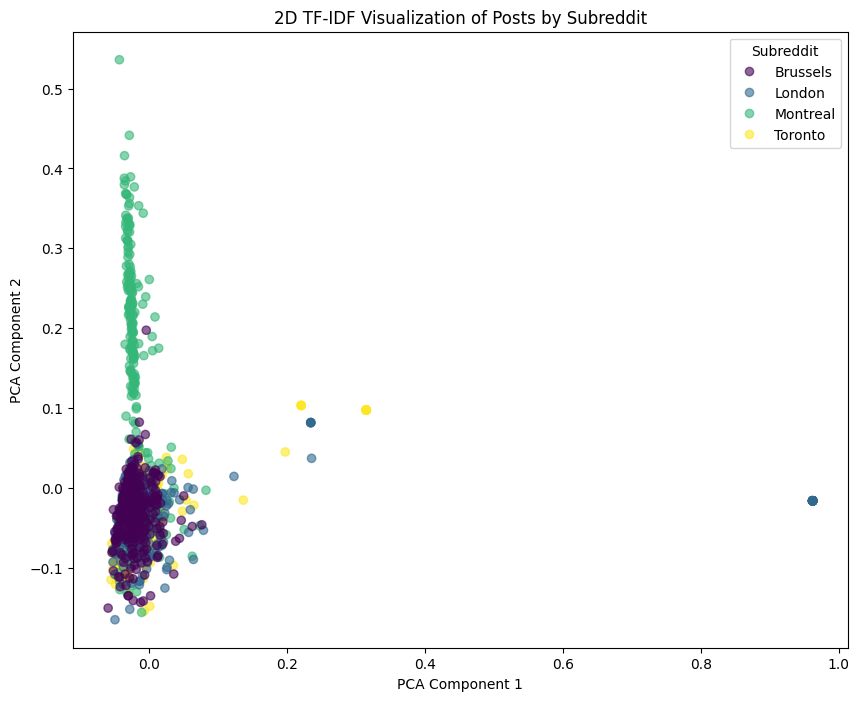

In [5]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text']).toarray()

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf)

# Map subreddits to color-coded categories
color_labels = train_data['subreddit'].astype('category').cat.codes

# Plot 2D TF-IDF visualization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color_labels, cmap="viridis", alpha=0.6)
plt.title('2D TF-IDF Visualization of Posts by Subreddit')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Convert legend_labels to a list to avoid ambiguity
legend_labels = list(train_data['subreddit'].astype('category').cat.categories)
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Subreddit")
plt.show()

In [6]:
class CustomBernoulliNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Laplace smoothing parameter

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        # Initialize counts and log priors
        self.log_class_priors = np.log(np.array([(y == c).sum() for c in self.classes]) / n_samples)
        self.feature_probs = np.zeros((n_classes, n_features))

        # Calculate conditional probabilities with Laplace smoothing
        for idx, c in enumerate(self.classes):
            X_class = X[y == c]
            class_count = X_class.sum(axis=0) + self.alpha
            total_count = X_class.shape[0] + 2 * self.alpha  # denominator with smoothing
            self.feature_probs[idx] = class_count / total_count
    
    def predict(self, X):
        log_likelihoods = X @ np.log(self.feature_probs.T) + (1 - X) @ np.log(1 - self.feature_probs.T)
        log_posteriors = log_likelihoods + self.log_class_priors
        return self.classes[np.argmax(log_posteriors, axis=1)]


In [7]:
# Train the custom Bernoulli Naïve Bayes model
custom_nb = CustomBernoulliNB(alpha=1.0)
custom_nb.fit(X_train_binary, y_train)

# Predict and evaluate
custom_nb_predictions = custom_nb.predict(X_val_binary)
custom_nb_accuracy = accuracy_score(y_val, custom_nb_predictions)
print(f'Custom Bernoulli Naïve Bayes Accuracy: {custom_nb_accuracy}')


Custom Bernoulli Naïve Bayes Accuracy: 0.6107142857142858


In [8]:
# Vectorize text using TF-IDF for Logistic Regression
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000, 
    lowercase=True,
    )
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Train Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
logreg_predictions = logreg_model.predict(X_val_tfidf)
logreg_accuracy = accuracy_score(y_val, logreg_predictions)
print(f'Logistic Regression Accuracy: {logreg_accuracy}')

Logistic Regression Accuracy: 0.6571428571428571


In [9]:
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Custom Bernoulli Naïve Bayes Cross-Validation
nb_cv_scores = []
for train_index, val_index in kf.split(X_train_binary):
    X_kf_train, X_kf_val = X_train_binary[train_index], X_train_binary[val_index]
    y_kf_train, y_kf_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    custom_nb = CustomBernoulliNB(alpha=1.0)
    custom_nb.fit(X_kf_train, y_kf_train)
    y_kf_pred = custom_nb.predict(X_kf_val)
    nb_cv_scores.append(accuracy_score(y_kf_val, y_kf_pred))

nb_mean_accuracy = np.mean(nb_cv_scores)
print(f'Custom Bernoulli Naïve Bayes Cross-Validation Accuracy: {nb_mean_accuracy}')

# Logistic Regression Cross-Validation
logreg_cv_scores = cross_val_score(logreg_model, X_train_tfidf, y_train, cv=kf, scoring='accuracy')
logreg_mean_accuracy = np.mean(logreg_cv_scores)
print(f'Logistic Regression Cross-Validation Accuracy: {logreg_mean_accuracy}')

# Determine the best model based on cross-validation accuracy
if logreg_mean_accuracy > nb_mean_accuracy:
    best_model = "Logistic Regression"
    best_accuracy = logreg_mean_accuracy
else:
    best_model = "Custom Bernoulli Naïve Bayes"
    best_accuracy = nb_mean_accuracy

print(f"Best Model: {best_model} with Accuracy: {best_accuracy}")


Custom Bernoulli Naïve Bayes Cross-Validation Accuracy: 0.6728939782190904
Logistic Regression Cross-Validation Accuracy: 0.6603859705317104
Best Model: Custom Bernoulli Naïve Bayes with Accuracy: 0.6728939782190904


In [11]:
# Load test data
test_file_path = '../datasets/Test.csv'
test_data = pd.read_csv(test_file_path, names=['review_id', 'text'], skiprows=1)

# Preprocess and vectorize test data
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

# Select the best model based on cross-validation accuracy
best_model = custom_nb if nb_mean_accuracy > logreg_mean_accuracy else logreg_model

# Vectorize test data based on the selected model
if best_model == logreg_model:
    # If Logistic Regression is the best model, use TF-IDF vectorizer
    X_test = tfidf_vectorizer.transform(test_data['processed_text'])
else:
    # If Custom Bernoulli Naïve Bayes is the best model, use CountVectorizer with binary features
    X_test = vectorizer.transform(test_data['processed_text']).toarray()

# Predict using the best model
test_predictions = best_model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'review_id': test_data['review_id'],
    'predicted_label': test_predictions
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Kaggle submission file created as 'submission.csv'")


Kaggle submission file created as 'submission.csv'
